In [1]:
#Requirement: 
#1. Use Python to develop a binary classification algorithm. 
#2. This algorithm shall detect the 'V' beats in Electrocardiogram (ECG), 
#   as shown in "Fig: Train". 

In [2]:
#Background:
#1. What's Electrocardiogram (ECG)? 
#   [https://en.wikipedia.org/wiki/Electrocardiography]
#2. What's V beat? (Premature ventricular contraction) 
#   [https://en.wikipedia.org/wiki/Premature_ventricular_contraction]
#3. Hint: Features of V beats: peak-to-peak intervals, peak amplitudes, peak inverted. 
#   [https://www.dropbox.com/s/qeodwvh8rkii2dp/v-beats-features.pdf?dl=0]

In [3]:
import pandas as pd
import numpy as np
# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Supporting functions:
%matplotlib inline
import wfdb
import matplotlib.pyplot as plt
def read_ecg(file_path):
    """
    output: ecg files, get signal, annotated peaks, annotated types
    input: ecg file id
    """
    signals, fields = wfdb.rdsamp(file_path)
    annotation = wfdb.rdann(file_path, 'atr')
    ecg_sig = signals[:,0]
    ecg_type = annotation.symbol
    ecg_peak = annotation.sample
    return ecg_sig, ecg_type, ecg_peak

def plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Train', npeak=10, len_sig=3000):
    """
    demo plot ecg signal with annotated peaks, annotated types
    """
    _, ax = plt.subplots()
    for i in range(0, npeak):
        ax.annotate(ecg_type[i], xy=(ecg_peak[i], -2))
    ax.plot(ecg_sig[0:len_sig])
    ax.plot(ecg_peak[0:npeak], ecg_sig[ecg_peak[0:npeak]], '*')
    ax.set_title(title)

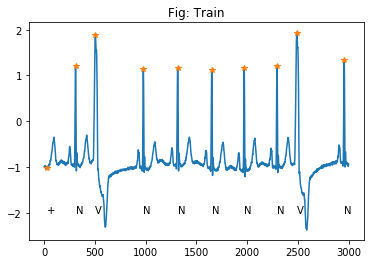

In [5]:
#What's included in the training database? 
#1. The training database contains a group of ECG signals and annotations: 
#2. In each annotation, the type of each beat is annotated on its peak (N, V, ...), 
#   For example: 
training_file_path = './database/train/a4'
ecg_sig, ecg_type, ecg_peak = read_ecg(training_file_path)
plot_ecg(ecg_sig, ecg_type, ecg_peak,len_sig=3000,npeak=10)

## <font color="blue" size=5>Data Preprocessing<font>
<font size=3>-  __Merging all the data into one Frame.<br><br>-  Checking if peak-to-peak distance is according to rule specified:__<br><br>|<-R->|<--2*RR-->|<br>
    ?&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;?&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;V&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;?</font>

In [6]:
df=pd.DataFrame()
df1=pd.DataFrame()

In [7]:
df['ecg_sig']=ecg_sig
df1['ecg_type']=ecg_type
df1['ecg_peak']=ecg_peak

In [8]:
def p2p(ar):
    res=[0,0]
    for i in range(2,len(ar)-1):
        n=int((ar[i+1]-ar[i-1])/(ar[i-1]-ar[i-2]))
        if n==2:
            res.append(1)
        else:
            res.append(0)
    res.append(0)
    return res
df1['p2p']=p2p(ecg_peak)

In [9]:
dfNew=pd.merge(df, df1, left_index=True, right_on='ecg_peak',how='outer')

In [10]:
dfNew['p2p']=dfNew['p2p'].fillna(0)

In [11]:
def isPeak(ecg):
    if ecg!='nan':
        return 1
    else:
        return 0
dfNew['isPeak']=dfNew['ecg_type'].apply(lambda ecg: isPeak(str(ecg)))

<font size=4>__Outcome to be predicted is: whether a signal is V or not?__</font>

In [12]:
def isV(ecg):
    if ecg!='V':
        return 0
    else:
        return 1
dfNew['Outcome']=dfNew['ecg_type'].apply(lambda ecg: isV(str(ecg)))

<font size=4>__Split Input Set into test and train__</font>

In [13]:
x=dfNew.drop(['Outcome','ecg_type'],axis=1)
y=dfNew['Outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [14]:
print(x.shape, y.shape)

(650000, 4) (650000,)


<br><br><br><font size=8 color="blue">__Model Experimentation__</font><br><br>

In [15]:
model_names = ['GBC', 'RFC']
model_acc = []
model_f1 = []

from sklearn.metrics import accuracy_score,f1_score 
models = []
models.append(GradientBoostingClassifier())
models.append(RandomForestClassifier())
names = []
y_predALL=[]

for model in models:
    y_pred = model.fit(x_train,y_train).predict(x_test)
    y_predALL.append(y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_acc.append(acc)
    model_f1.append(f1)
    
# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'model_acc': model_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'model_f1': model_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

C:\Users\User\Miniconda3\envs\CS5242\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


       model_acc  acc_mean
Model                     
GBC     0.999969       1.0
RFC     0.999982       1.0
avg     0.999975       1.0


       model_f1  F1_mean
Model                   
GBC    0.999969      1.0
RFC    0.999981      1.0
avg    0.999975      1.0


<font size=4>__Plotting Confusion Matrix__</font>

Confusion matrix, without normalization
[[162396      4]
 [     1     99]]


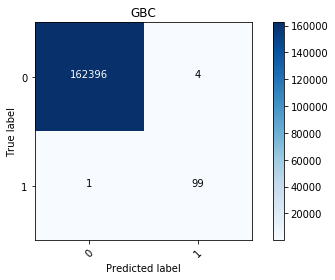

Confusion matrix, without normalization
[[162399      1]
 [     2     98]]


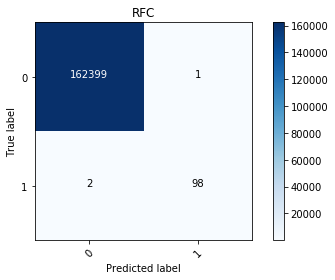

In [16]:
import itertools
def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
import seaborn as sb
from sklearn.metrics import confusion_matrix
for i in range(len(models)):
    cnf_matrix_1 = confusion_matrix(y_test, y_predALL[i])
    plot_confusion_matrix(cnf_matrix_1,title=model_names[i])

<font size=5>__Checking best model parameters__</font>

In [17]:
models[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<font size=5>__Hyper-parameter Tuning using GridSearchCV__</font>

In [18]:
from sklearn.model_selection import GridSearchCV

n_est=[10, 50]
class_w=[{0:1,1:1},{0:1,1:2}]
cri=['gini']
tuned_parameters = [{'n_estimators':n_est,'criterion':cri,'class_weight':class_w,'max_features': [ 'sqrt']}]
gridRFC = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10, scoring='recall' )
gridRFC.fit(x_train,y_train)
print(gridRFC.best_params_)
print()
print("Best score:")
print()
print(round(gridRFC.best_score_,3))

{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}

Best score:

0.986


<font size=5>__Checking the confusion matrix for best model__</font>

C:\Users\User\Miniconda3\envs\CS5242\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion matrix, without normalization
[[162399      1]
 [     2     98]]


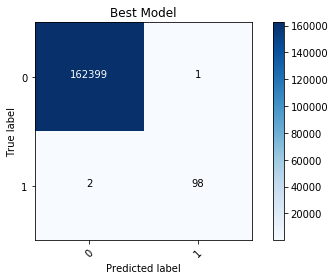

In [19]:
best_model=RandomForestClassifier(max_features='sqrt')
best_pred=best_model.fit(x_train,y_train).predict(x_test)
cnf_matrix_1 = confusion_matrix(y_test, best_pred)
plot_confusion_matrix(cnf_matrix_1,title="Best Model")

<font size=5>__Training best model on entire input data__</font>

In [20]:
best_model=RandomForestClassifier(max_features='sqrt')
best_model.fit(x,y)

C:\Users\User\Miniconda3\envs\CS5242\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<BarContainer object of 4 artists>

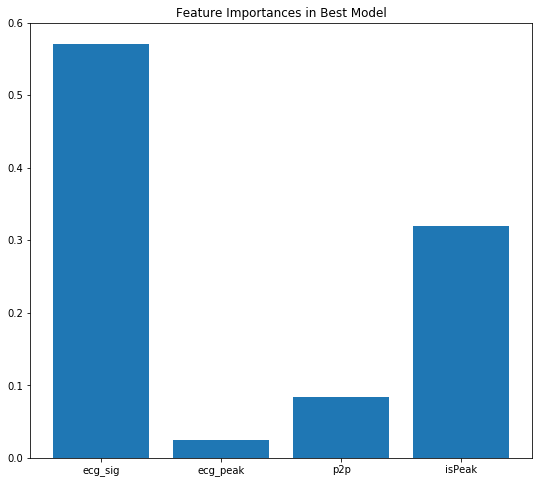

In [21]:
imp=best_model.feature_importances_
plt.figure(1, figsize=(9, 8))
plt.title('Feature Importances in Best Model')
plt.bar(x=x.columns,height=imp)

# Reading Test Data

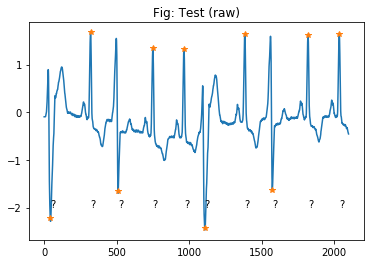

In [22]:
#What's included in the testing database? 
#1. The testing database contains a group of ECG signals. However,  
#2. Type of each beat is unknown (?, ?, ...). For example: 
testing_file_path = './database/test/b2'
ecg_sig, ecg_type, ecg_peak = read_ecg(testing_file_path)
plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Test (raw)', len_sig=2100)

<font size=5>__Preprocessing test data__</font>

In [23]:
dfTest=pd.DataFrame()
dfTest1=pd.DataFrame()
dfTest['ecg_sig']=ecg_sig
dfTest1['ecg_type']=ecg_type
dfTest1['ecg_peak']=ecg_peak
dfTest1['p2p']=p2p(ecg_peak)
dfTestNew=pd.merge(dfTest, dfTest1, left_index=True, right_on='ecg_peak',how='outer')
dfTestNew['p2p']=dfTestNew['p2p'].fillna(0)
dfTestNew['isPeak']=dfTestNew['ecg_type'].apply(lambda ecg: isPeak(str(ecg)))

# Predicting for Test Data

In [24]:
dfTestNew['Outcome']=best_model.predict(dfTestNew.drop(['ecg_type'],axis=1))

In [25]:
dfTestNew['ecg_type']=dfTestNew['Outcome'].apply(lambda outC: 'V' if outC==1 else '?')

In [26]:
ecg_type=dfTestNew.iloc[ecg_peak]['ecg_type'].tolist()

# Plotting only V beats

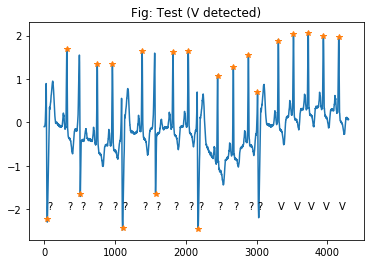

In [27]:
#Requirement: 
#1. develop an algorithm which identify all possible 'V' beats. 

#```
#Hint: use train a machine learning model to predict (e.g. scikit-learn library)
#a. segmentation based on peaks.
#b. feature extraction for each segment.
#c. initialize a classifier.
#d. train, evaluate, test.
#```

#2. The indentified beat shall be assigned as 'V'. For example:  
# ecg_type[0] = 'V' #assume the algorithm detected
# ecg_type[2] = 'V' #assume the algorithm detected
# ecg_type[5] = 'V' #assume the algorithm detected
# ecg_type[7] = 'V' #assume the algorithm detected
plot_ecg(ecg_sig, ecg_type, ecg_peak,title='Fig: Test (V detected)', len_sig=4300,npeak=20)


In [28]:
#3. The assigned 'V' beat info shall be exported to WFDB format (*.test), 
#   and sent back to Biofourmis. 
wfdb.wrann('b2', 'test', ecg_peak, ecg_type, write_dir='./database/test/')